# Basic regression examples using GPy
In this example I'll use the GPy library (http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/index.ipynb) to estimate a 1-dimensional function following the official guide from http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb. In Part 1 & 2 a data set of form $\{x_i,y_i\}$ is given where $i = 1,..., N$ is the index of the observation and $N$ the total number of observations made. In Part 3 the data set is extended by an observation and the resulting posterior distribution of the Gaussian Process (GP) is plotted iteratively until a certain number $N$ of observations is made. The measurement locations are chosen randomly. Part 4 shows the impact of optimizing the hyperparameters before predicting with the GP.

## Gaussian Processes
This tutorial does not provide a broad introduction into Bayesian Optimization nor Gaussian Processes. For the later I recommend you to take a look at the work by C. E. Rasmussen & C. K. I. Williams. They provide a great overview and understanding on GPs. Please follow the link to the book: http://www.gaussianprocess.org/gpml/chapters/RW.pdf

## Part 1 Estimation of a Gaussian Process based posterior on noise free data
This example will estimate a Gaussian Process (GP) posterior based on a given, randomly chosen, sample set. The set contains $N=20$ observations of an unknown function. Assuming an ideal enviroment we neglect possible independet Gaussian white noise. The ground truth we try to estimate is a sinus of the form 
\begin{equation*}
y_{true} = \sin(2\pi f)
\end{equation*}
With a frequency of $0.5Hz$. 

The measurement model will be 
\begin{equation*}
y_i = \sin(2\pi f x_i)
\end{equation*}
leading to a set of form $\{x_i,y_i\}$ and $i = [1,..., 20]$

In [1]:
import GPy
import numpy as np
import matplotlib
import math
import plotly
%matplotlib inline
plt = matplotlib.pyplot
np.random.seed(9)
GPy.plotting.change_plotting_library('matplotlib')
#plotly.tools.set_credentials_file(username='Toffl', api_key='CrOP9AtmUVS8pSDgh0L2')

In [19]:
fontsize_label = 24
fontsize_legend = 20
fontsize_ticks = 20
linewidth = 3
markeredgewidth = 3
markersize=13
matplotlib.rcParams['figure.figsize'] = (16, 8)

In [20]:
def plot2D(mean, var, *argv):
    '''
    Plot a 2D estimate based on a Gaussian Process estimate of some function f
    
    Mean and Variance of the prediction as well as a not known number of arrays is passed to this plotting function. 
    Each array contains an object that is plotted.The array has to have the following structure: 
    [xaxis, yaxis, "label", "marker"] where "marker" is an optional parameter
    
    For colors to work properly the following convention should be minded: 
    1. Array is the ground trouth if known
    2. Array is the estimated mean
    3. Array is the estimated variance
    '''
    
    fig = plt.figure()
    for arg in argv:
        if len(arg) == 4:
            plt.plot(arg[0], arg[1], arg[3], mew=markeredgewidth, label=arg[2], lw=linewidth, markersize=markersize)
        else:
            plt.plot(arg[0], arg[1], mew=markeredgewidth, label=arg[2], lw=linewidth, markersize=markersize)
    # Plot variance
    if mean is not None and var is not None:
        plt.fill_between(X[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C1', alpha=0.2, label='Var($\hat{f(x)}$)')
    # Format plot
    plt.legend(prop={'size': fontsize_legend}, loc=4)
    plt.xlabel('x', fontsize=fontsize_label)
    plt.ylabel('f(x)', fontsize=fontsize_label)
    plt.xticks(fontsize=fontsize_ticks)
    plt.yticks(fontsize=fontsize_ticks)
    plt.grid()

The following code block shows the creation of the data set. The whole input space is defined in an intervall of $x_{interval} = [-3,3]$ and contains $100$ points. The sample set is created according to the definition given before. The sample set as well as the ground truth are plotted. Note that the samples are part of the ground truth due to the absence of noise.

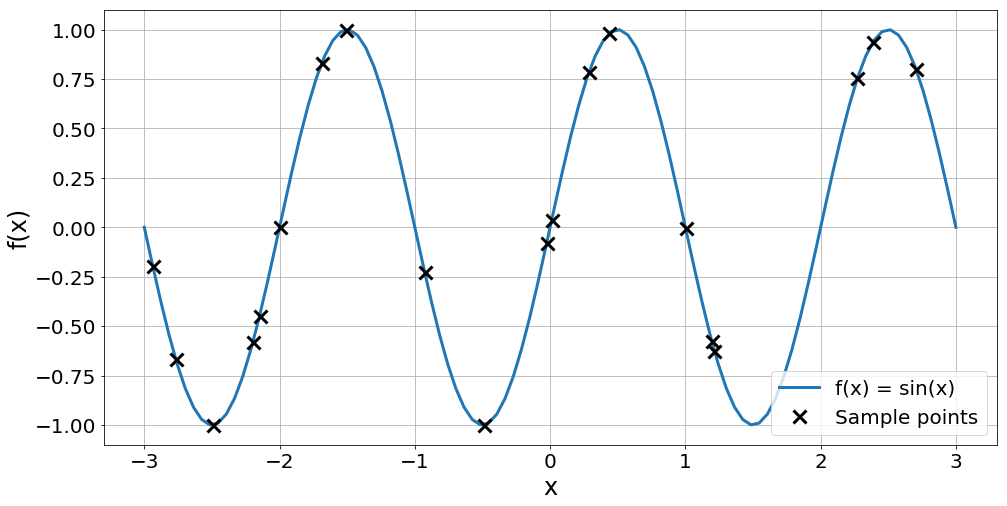

In [21]:
np.random.seed(9)
# Set some parameters
f = 0.5
N = 20
sigma_n = 0.0
# Build data sets
X = np.linspace(-3., 3., 100).reshape(100, 1)
Y_true = np.sin(X * (2 * math.pi * f))
X_sample = np.random.uniform(-3.,3.,(N,1))
Y_sample = np.sin(X_sample * (2 * math.pi * f))

plot2D(None, None, [X, Y_true, 'f(x) = sin(x)'], [X_sample, Y_sample, 'Sample points', 'kx'])

Now we construct a Gaussian Process Regression model by creating a kernel and  submitting the sample set as well and the kernel to the GPFlow library. 

The model has three parameters. The kernel function is part of the commonly used matern kernel class which is a stationary. Stationary in this context means that the function depends on distances between points. The characteristic length scale is set to $l=0.3$. The variance is set to $\sigma^2 = 1$. Variance is added for numerical reasons since during analysis the matrix has to be inverted at some point and if the distances between data points is small the matrix maybe becomes singular and we run into numerical problems during inversion of the covariance matrix.

The variance of the noise as part of the likelihood is set to $\sigma_n^2 = 0.0$ since we assume no measurement noise. The parameters will not be optimized in this case. 

After defining the parameters the model is compiled, fitted to the data and can be used to predict the estimated function for a given intervall. A more detailed description of the hyperparameters can be found in http://www.gaussianprocess.org/gpml/chapters/RW.pdf or https://drafts.distill.pub/gp/

In [22]:
# Construct models with initial guess
k = GPy.kern.src.stationary.Matern52(input_dim=1, variance=1., lengthscale=0.3)
# GPRegression(X, Y, kernel=None, Y_metadata=None, normalizer=None, noise_var=1.0, mean_function=None)
m = GPy.models.GPRegression(X_sample,Y_sample,k, noise_var=sigma_n)
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
Mat52.variance,1.0,+ve,
Mat52.lengthscale,0.3,+ve,
Gaussian_noise.variance,0.0,+ve,


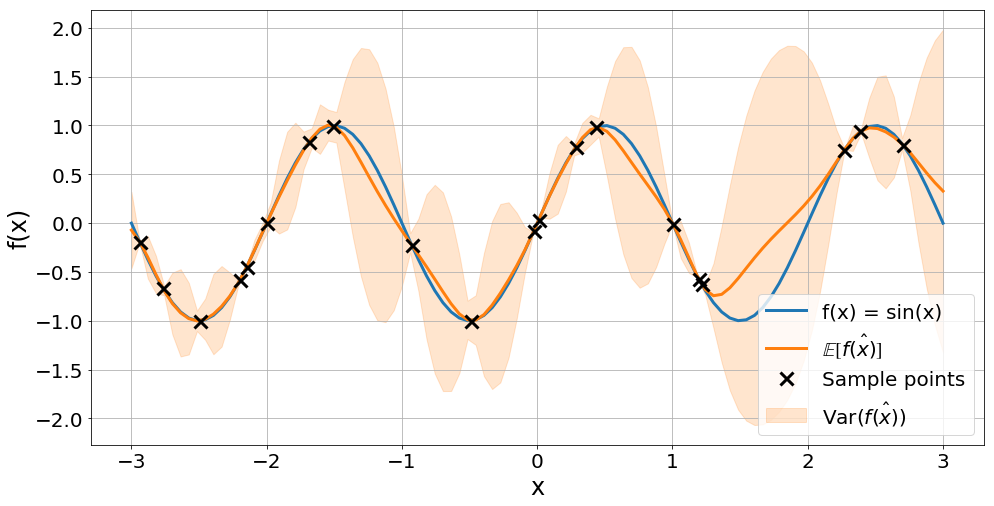

In [23]:
# Predict with model
mean, var = m.predict(X)
# Plot posterior
fig = plot2D(mean, var, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_sample, 'Sample points', 'kx'])

This plot shows the true, usually not known function $f(x)$ (blue) and the posterior distribution of the surrogate model. The mean and the variance of the prediction (orange) is also shown. Note how the sample points influence the behavior of the prediction: The variance is small if we have observations a a given point $x$. Also observerd is the measurement model by looking at the mean of the posterior: Is passes through all observations since we assume them to be noise free by setting the likelihood of the variance to $\sigma_n^2=0.0$.

## Part 2 - Estimation of a Gaussian Process based posterior on existing, noisy data
This example will estimate a Gaussian Process (GP) posterior based on a given, randomly chosen, sample set. The set contains $N=20$ observations of an unknown function. This function could be anything but we assume its evaluation to be expensive which is why we represent it by a surrogate function (the Gaussian Process). Assuming that we tackle a real world problem we add Gaussian white noise $\epsilon$ with zero mean and variance $\sigma_n^2=0.1$ to the data.
The ground truth we try to estimate is a sinus of the form 
\begin{equation*}
y_{true} = \sin(2\pi f)
\end{equation*}
With a frequency of $0.5Hz$. 

The final measurement model will be 
\begin{equation*}
y_i = \sin(2\pi f x_i) + \epsilon\\
\epsilon \sim \mathcal{N}(0,\sigma_n^2)
\end{equation*}
leading to a set of form $\{x_i,y_i\}$ and $i = [1,..., 20]$

In [33]:
# Set some parameters
sigma_n = 0.1
# Construct models with initial guess
k = GPy.kern.src.stationary.Matern52(input_dim=1, variance=1., lengthscale=0.3)
# GPRegression(X, Y, kernel=None, Y_metadata=None, normalizer=None, noise_var=1.0, mean_function=None)
m = GPy.models.GPRegression(X_sample,Y_sample,k, noise_var=sigma_n)
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
Mat52.variance,1.0,+ve,
Mat52.lengthscale,0.3,+ve,
Gaussian_noise.variance,0.1,+ve,


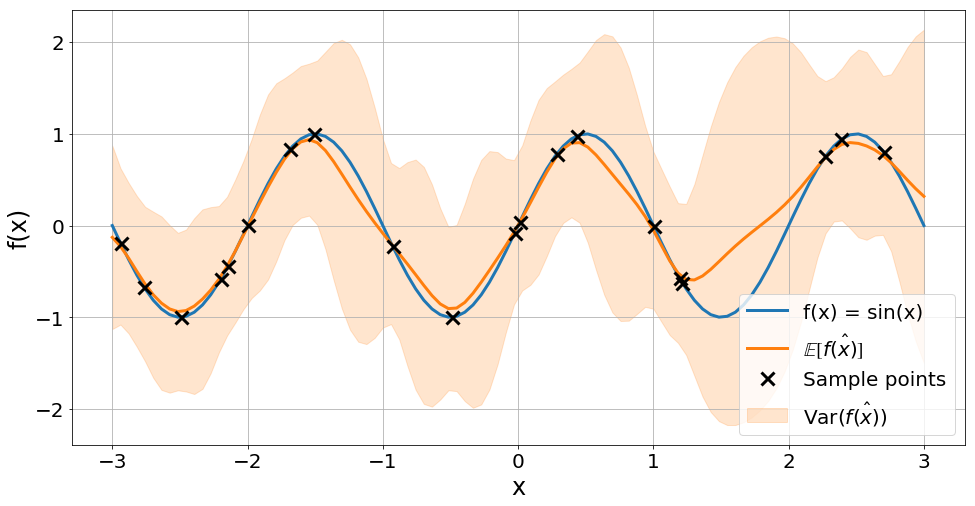

In [27]:
# Predict with model
mean, var = m.predict(X)
# Plot posterior
fig = plot2D(mean, var, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_sample, 'Sample points', 'kx'])

We now have a GP that predicted on the same data as before but the change in one parameter caused a tremendous difference in the obtained posterior. By simply assuming noise in the data the GP's mean is not forced to pass through all the samples anymore.

This parameterization is significantly different from the intuition. Intuitively one would add noise to the sample set but not change the likelihood parameter. While this is also a valid thing to do it adds a second level of noise to the data which would be accounted for by parameterizing the GP correctly.  

The following plot shows what happens if the GP is parameterized as in Part 1 and noise is added to the data:

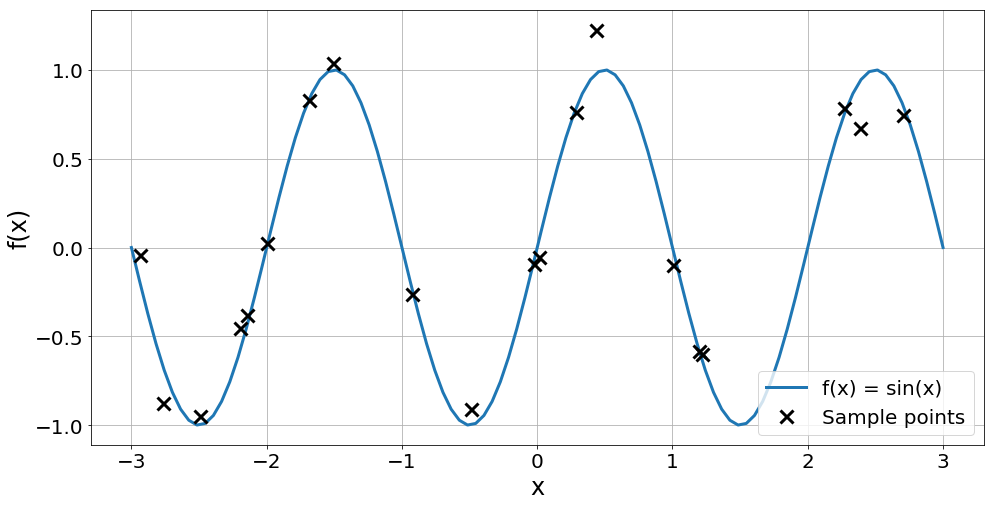

In [29]:
# Set some parameters
sigma_n = 0.1
# np.random.randn(N,1): 
# Create an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
noise = np.random.randn(N,1) * sigma_n
Y_noise = Y_sample + noise

fig = plot2D(None, None, [X, Y_true, 'f(x) = sin(x)'], [X_sample, Y_noise, 'Sample points', 'kx'])

In [30]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = GPy.kern.src.stationary.Matern52(input_dim=1, variance=1., lengthscale=0.3)
# GPRegression(X, Y, kernel=None, Y_metadata=None, normalizer=None, noise_var=1.0, mean_function=None)
m = GPy.models.GPRegression(X_sample,Y_noise,k, noise_var=sigma_n)
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
Mat52.variance,1.0,+ve,
Mat52.lengthscale,0.3,+ve,
Gaussian_noise.variance,0.0,+ve,


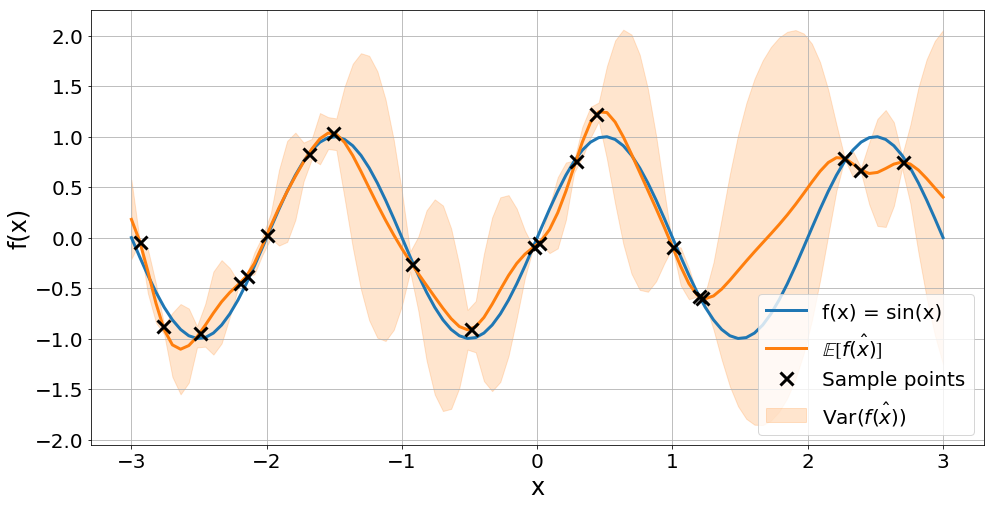

In [32]:
# Predict with model
mean, var = m.predict(X)
# Plot posterior
fig = plot2D(mean, var, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_noise, 'Sample points', 'kx'])

## Part 3 - Progression of a Gaussian Process posterior based on sequential data
The example before estimated a Gaussian Process (GP) posterior based on a given sample set. In the following setup no data is known when the GP is defined. A synthetic sample set is constructed and we end up having $N=10$ observations which we fit the GP to. The sample set to which the GPR is learned will be extended by one sample each iteration of a loop. Every iteration the ground truth is plotted to show the fitting of the posterior distribution after observing data.

The ground truth we try to estimate is a sinus of the form 
\begin{equation*}
y_{true} = \sin(2\pi f)
\end{equation*}
With a frequency of $0.5Hz$. To simulate a realistic scenario we add some Gaussian white noise $\epsilon$ with zero mean and variance $\sigma_n^2=0.1$ to the data which can be seen as either systematic or random measurement noise of whatever sensor we are modelling.
\begin{equation*}
y_{sample} = \sin(2\pi f) + \epsilon\\
\epsilon \sim \mathcal{N}(0,\sigma_n^2)
\end{equation*}



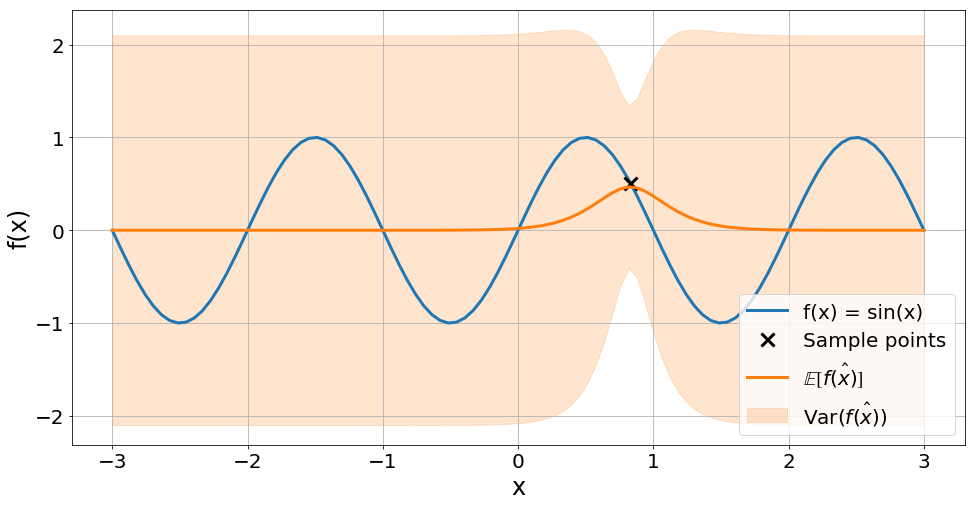

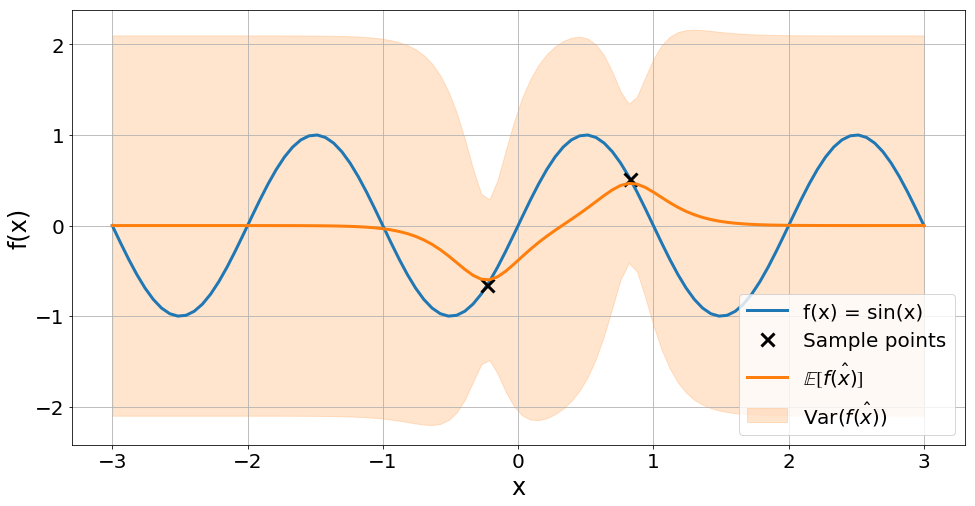

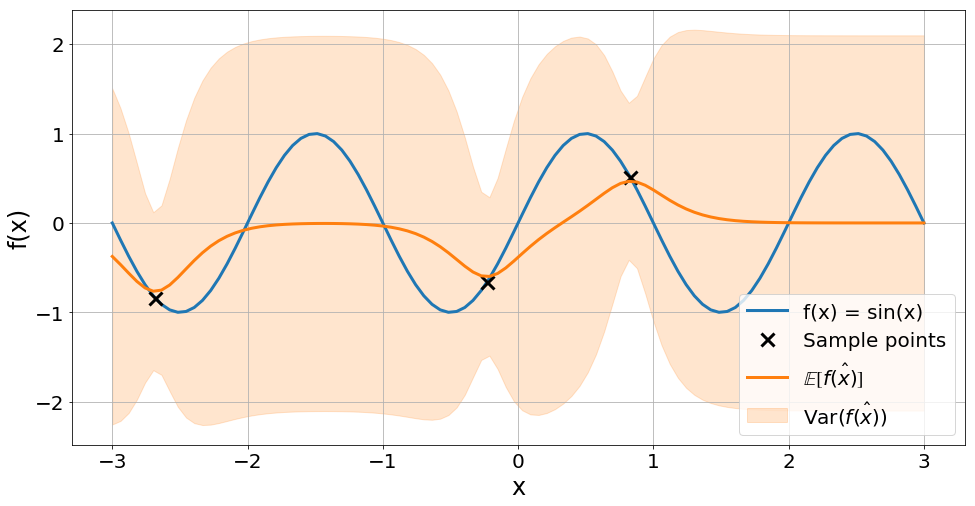

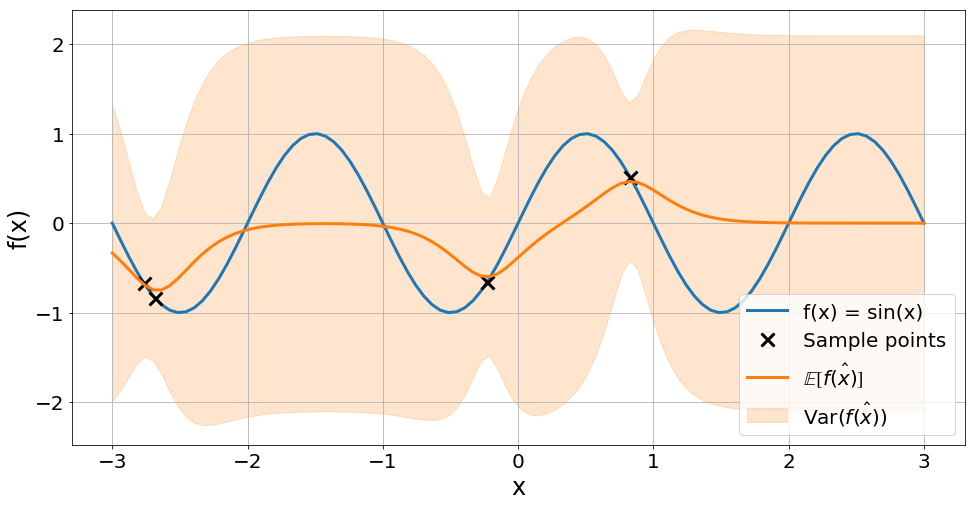

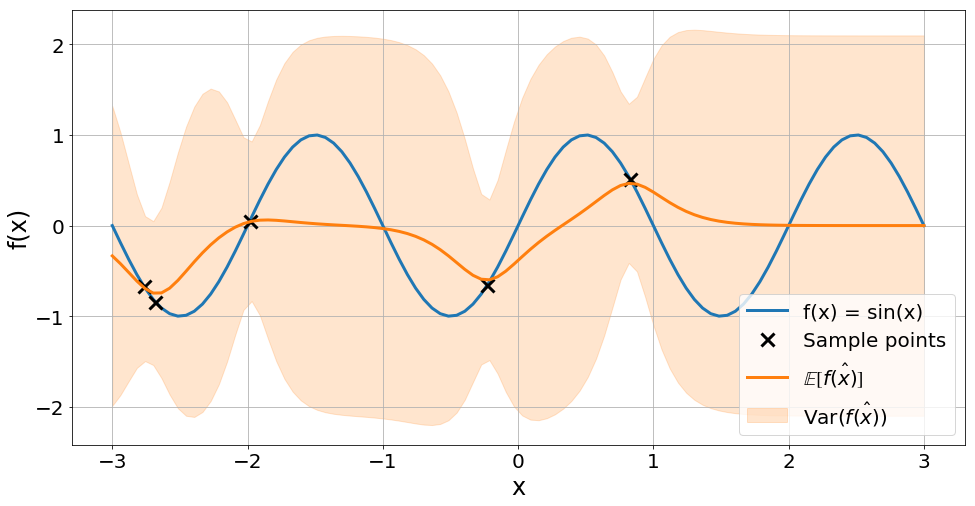

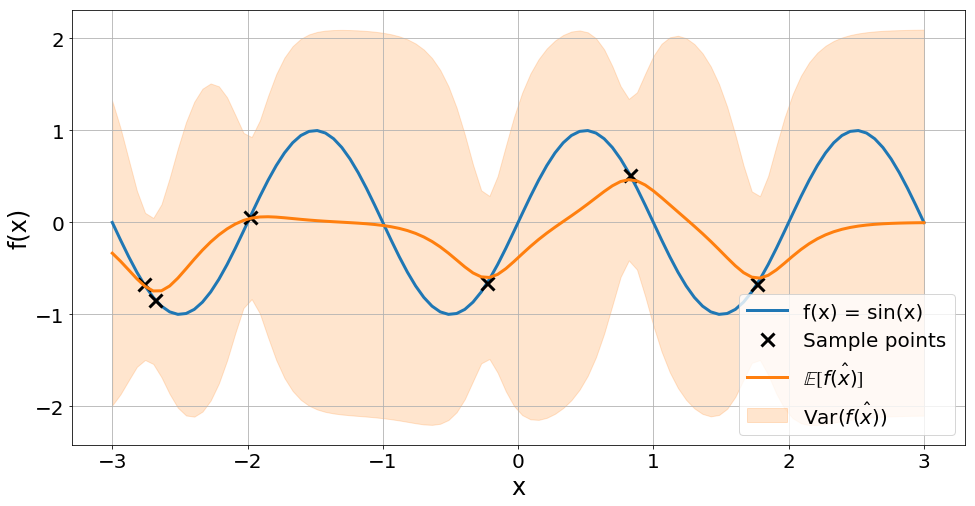

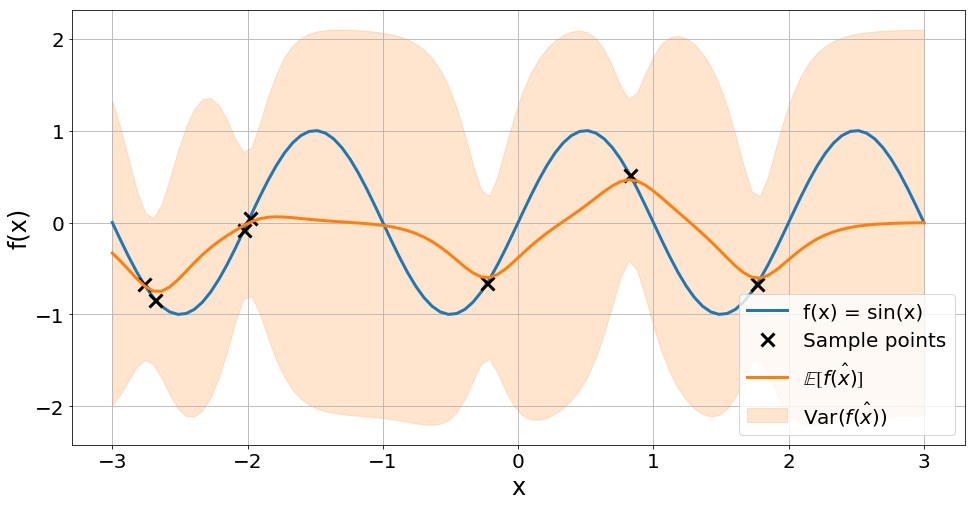

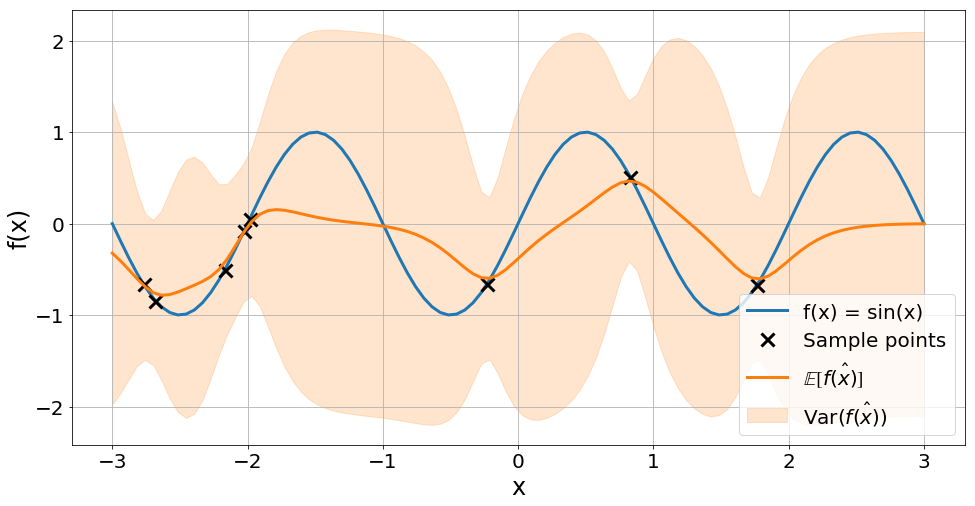

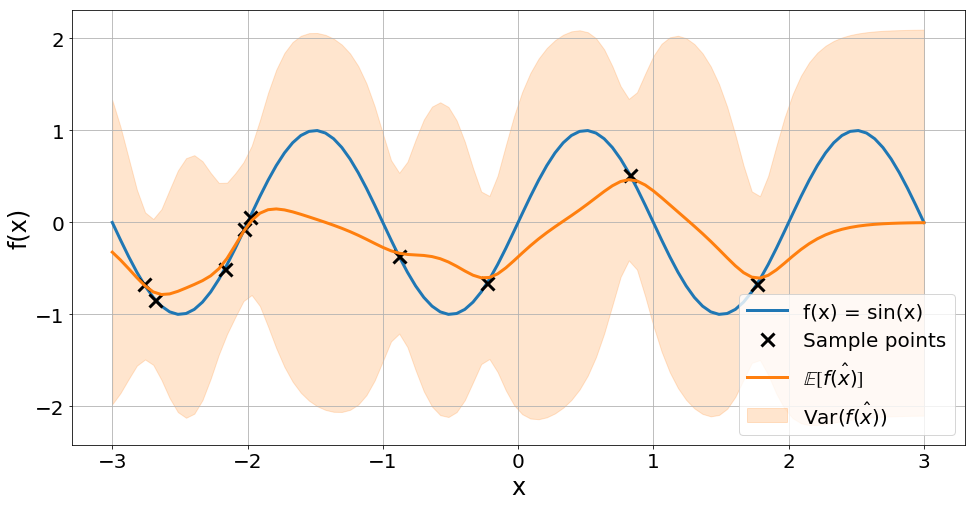

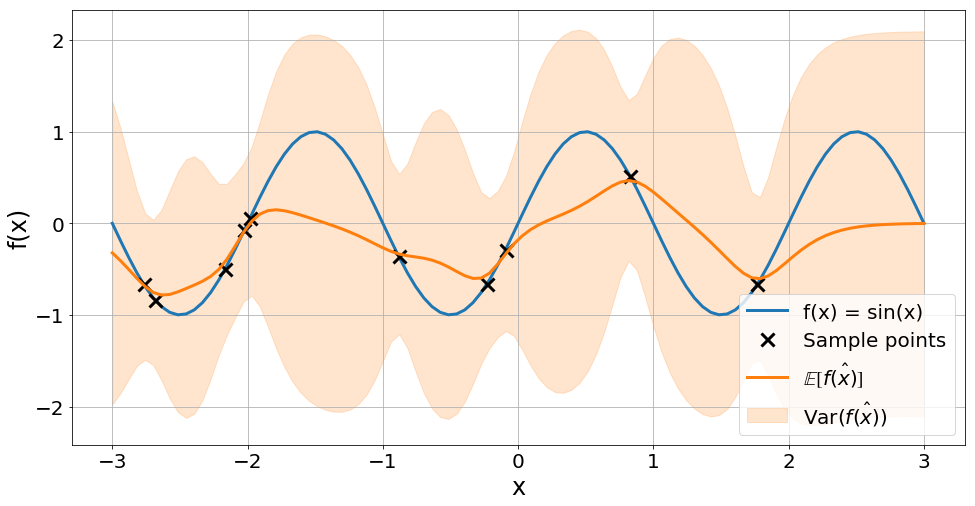

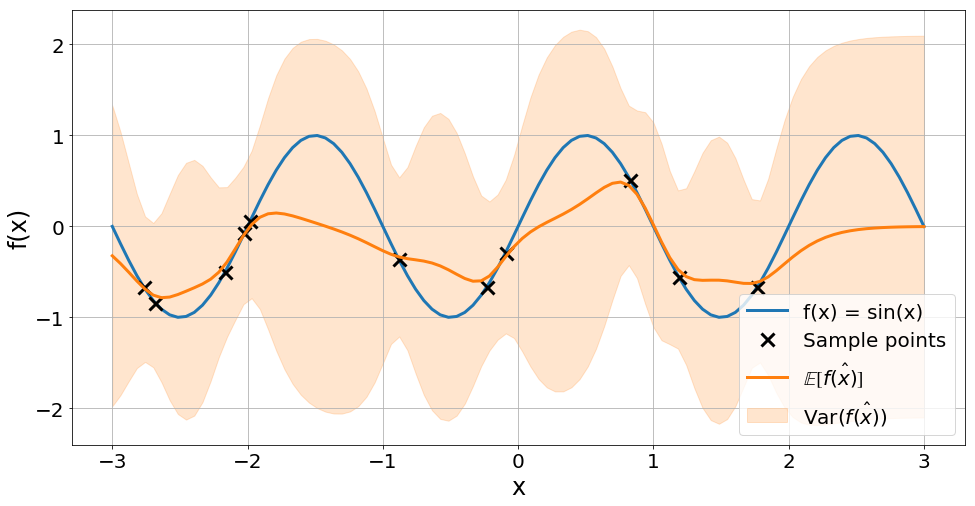

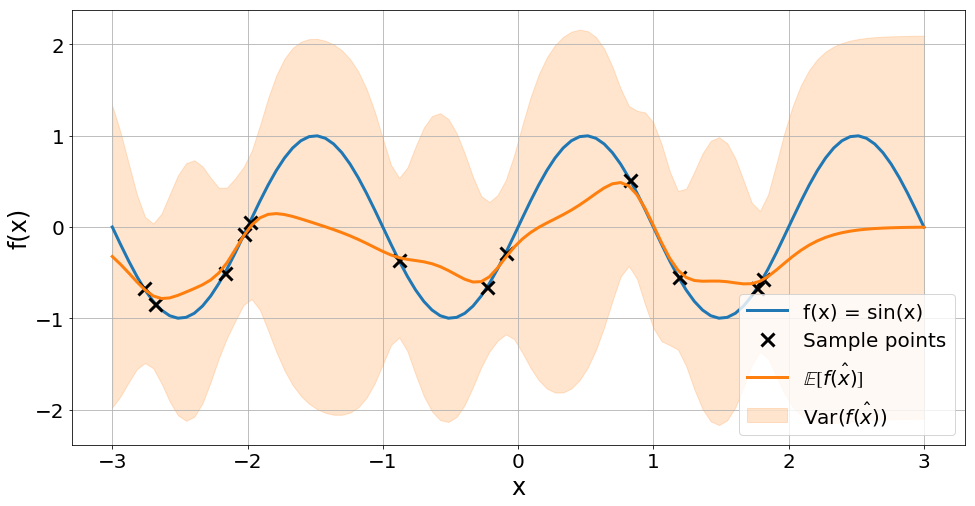

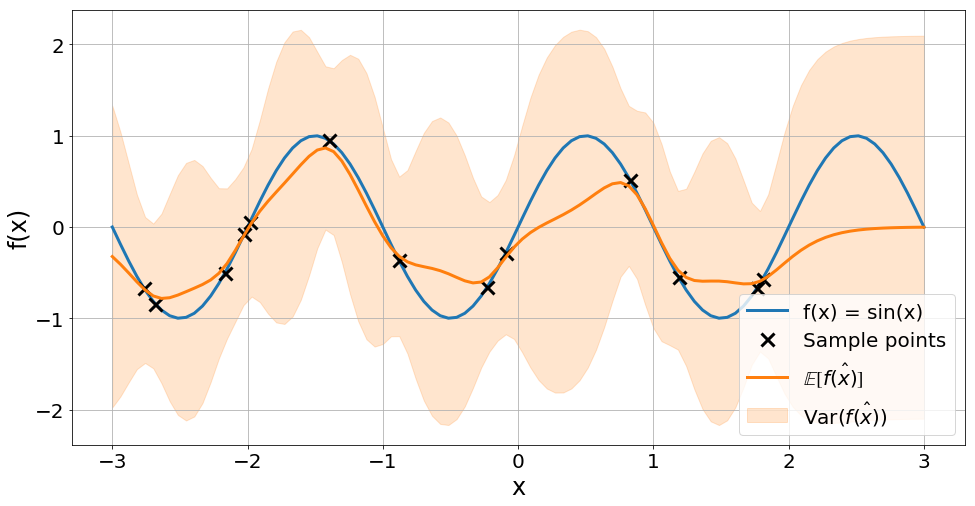

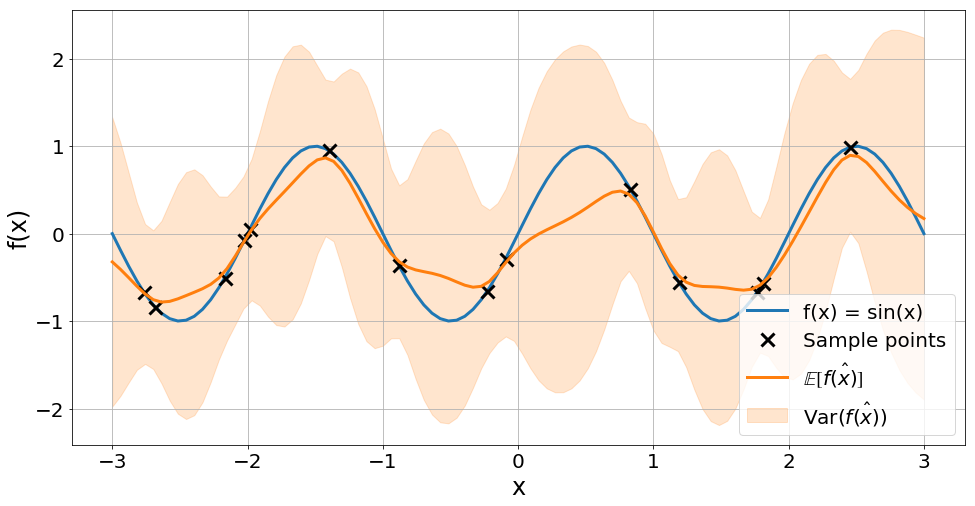

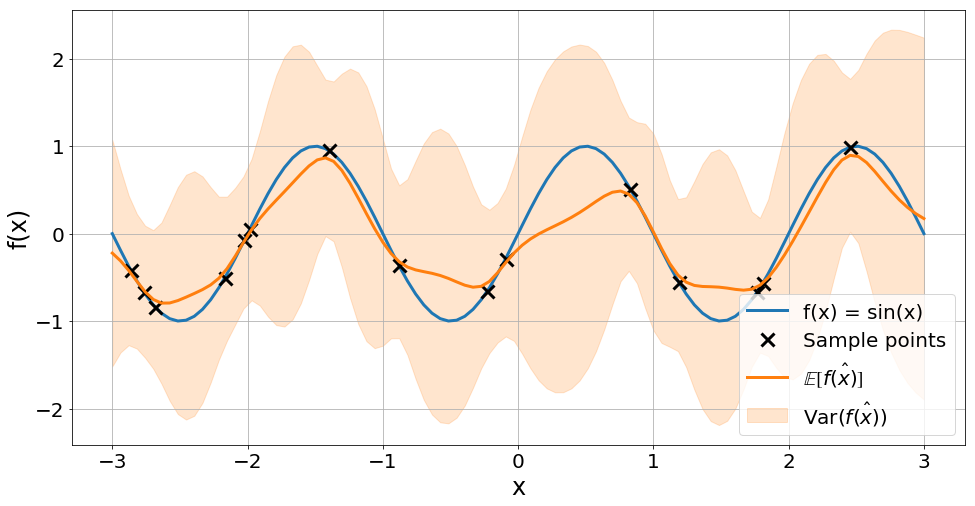

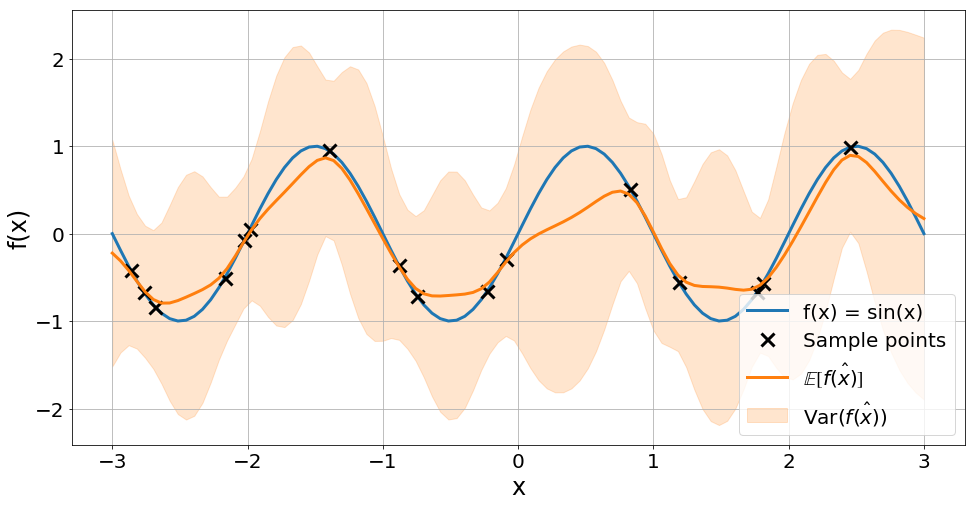

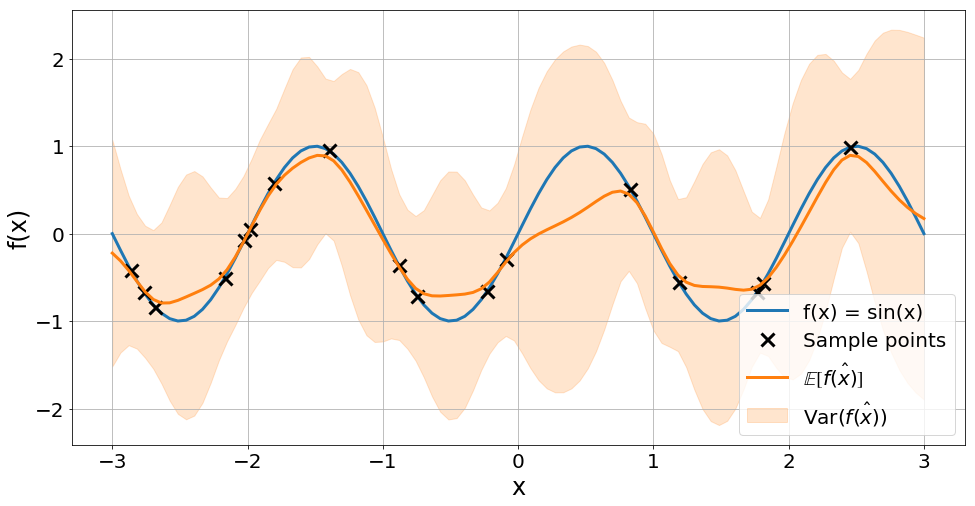

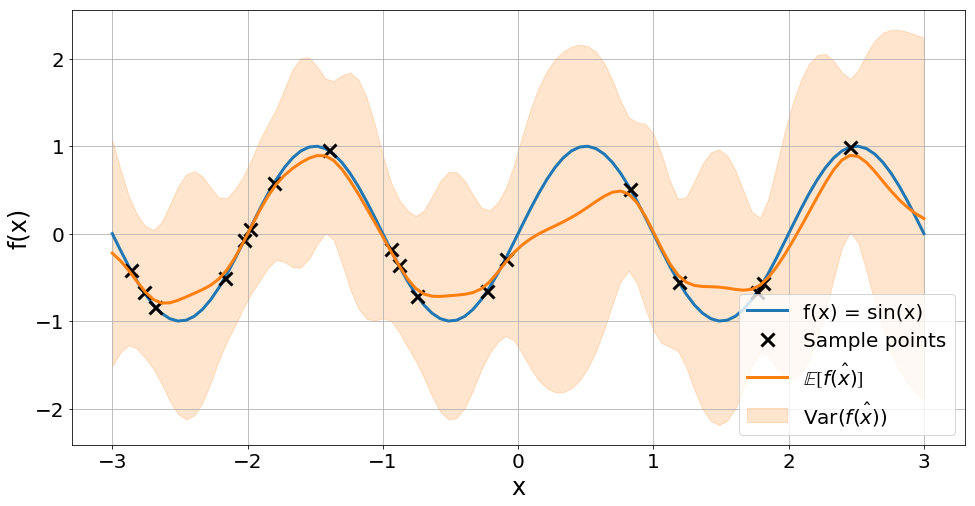

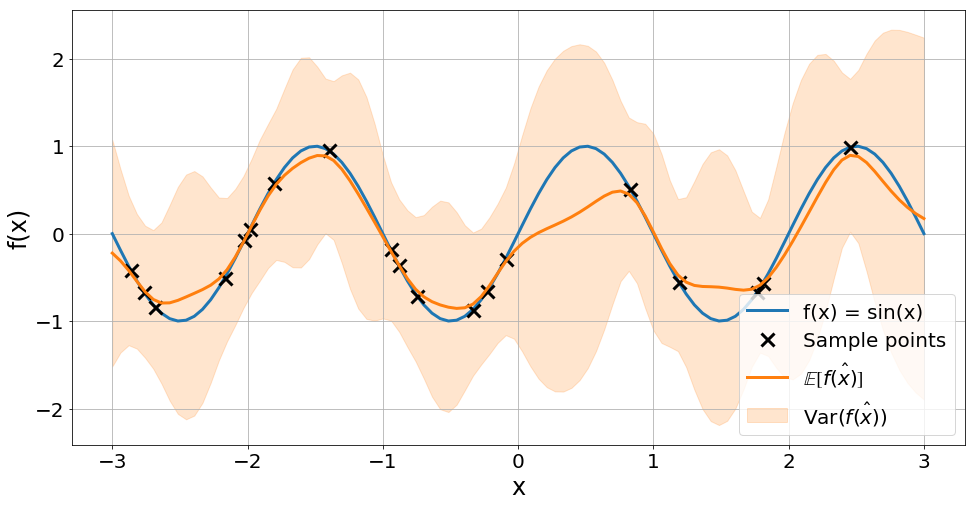

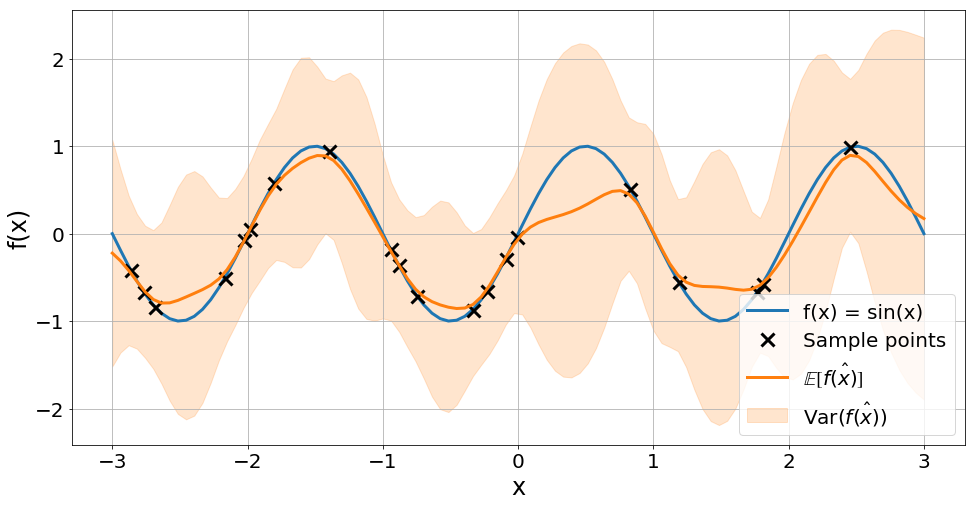

In [37]:
# Set some parameters
k = GPy.kern.src.stationary.Matern52(input_dim=1, variance=1., lengthscale=0.3)
N_samples = 20
sigma_n = 0.1
f = 0.5 # Frequency for ground truth function

# Build data sets
X = np.linspace(-3., 3., 100).reshape(100, 1)
Y_true = np.sin(X * (2 * math.pi * f))

X_sample = np.array([])
for i in range(N_samples):
    X_sample = np.append(X_sample, np.random.uniform(-3.,3.,(1,1))).reshape(i+1,1)
    Y_sample = np.sin(X_sample * (2 * math.pi * f))
    
    # Estimate model on samples assuming they distorted by noise
    m = GPy.models.GPRegression(X_sample,Y_sample,k, noise_var=sigma_n)
#     display(m)  
    
    # Predict with model
    mean, var = m.predict(X)
    
    # Plot 
    plot2D(mean, var, [X, Y_true, 'f(x) = sin(x)'], [X_sample, Y_sample, 'Sample points', 'kx'], 
           [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'])
    
plt.show()

The posterior is fitted to the observations each time a sample is added to the set. 

## Part 4 - Hyperparameter tuning
For the last part we return to the scenario of Part 2 where we assumed our observations to be noisy. The hyperparameters where guessed so far but GPFlow enables us to optimize them with respect to teh given data set. It provides a Maximum likelihood estimation of $\theta$ where $\theta$ is a vector of GP parameters (legnthscale, kernel variance, etc). 

Usually the hyperparameters are estimated using the Marginal likelihood. "A closed-form solution to maximizing the marginal likelihood cannot be found in general. In practice, we use gradient-based optimization algorithms (e.g., conjugate gradients or BFGS) to find a (local) optimum of the marginal likelihood" [https://drafts.distill.pub/gp/].

The maximum likelihood estimation is prone to overfitting but we will use it in this example since it is provided by the library. By default, GPflow plugs into the L-BFGS-B algorithm via scipy. Here are the parameters before optimization:

In [47]:
# Recreate data set
# Set some parameters
f = 0.5
N = 20
# Build data sets
X = np.linspace(-3., 3., 100).reshape(100, 1)
Y_true = np.sin(X * (2 * math.pi * f))
X_sample = np.random.uniform(-3.,3.,(N,1))
Y_sample = np.sin(X_sample * (2 * math.pi * f))

In [60]:
# Change noise parameter
sigma_n = 0.1
# Construct models with initial guess
sigma_n = 0.1
# Construct models with initial guess
k = GPy.kern.src.stationary.Matern52(input_dim=1, variance=1., lengthscale=0.3)
# GPRegression(X, Y, kernel=None, Y_metadata=None, normalizer=None, noise_var=1.0, mean_function=None)
m = GPy.models.GPRegression(X_sample,Y_sample,k, noise_var=sigma_n)
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
Mat52.variance,1.0,+ve,
Mat52.lengthscale,0.3,+ve,
Gaussian_noise.variance,0.1,+ve,


In [61]:
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 30)


Optimization restart 1/30, f = -8.938291499287274
Optimization restart 2/30, f = -8.938291419719583
Optimization restart 3/30, f = -8.938291509769797
Optimization restart 4/30, f = -8.93829124974829
Optimization restart 5/30, f = -8.938282307240032
Optimization restart 6/30, f = -8.938291532402364
Optimization restart 7/30, f = -8.938291080629245
Optimization restart 8/30, f = -8.93829151629617
Optimization restart 9/30, f = -8.938291510945431
Optimization restart 10/30, f = -8.938291496944874
Optimization restart 11/30, f = -8.938291401888538
Optimization restart 12/30, f = -8.938291481271714
Optimization restart 13/30, f = -8.938291436952165
Optimization restart 14/30, f = -8.938291503927923
Optimization restart 15/30, f = -8.938291477114532
Optimization restart 16/30, f = -8.93829149631968
Optimization restart 17/30, f = -8.938291335247381
Optimization restart 18/30, f = -8.93829151824572
Optimization restart 19/30, f = -8.938291518064188
Optimization restart 20/30, f = -8.938291498

In [62]:
display(m)

GP_regression.,value,constraints,priors
Mat52.variance,3.059336687622496,+ve,
Mat52.lengthscale,1.2299531316632875,+ve,
Gaussian_noise.variance,1.1183873036306837e-16,+ve,


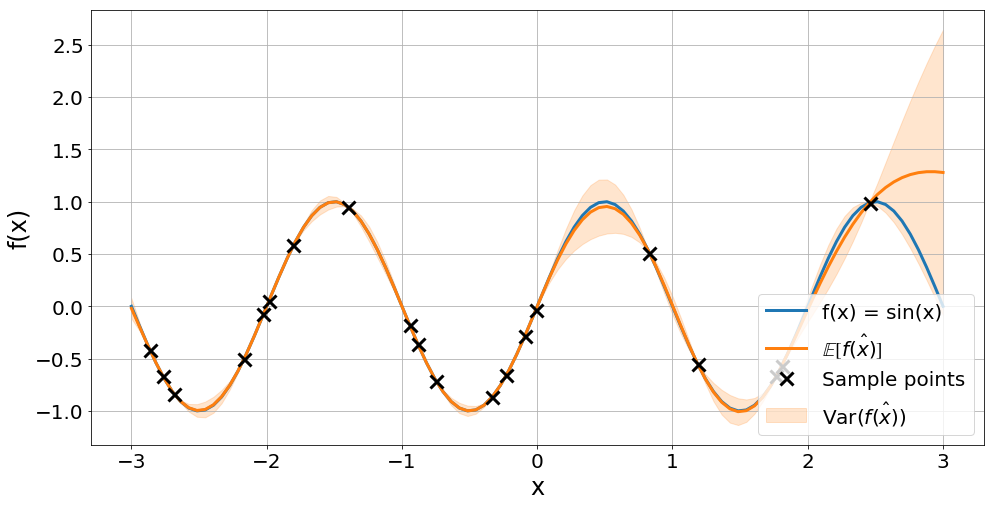

In [63]:
# Predict with model
mean, var = m.predict(X)
# Plot posterior
fig = plot2D(mean, var, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_sample, 'Sample points', 'kx'])

Note how different the posterior looks. The optimized hyperparameters result in a way better prediction. 